In [1]:
import os
from PIL import Image
from pathlib import Path
import torch as t
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import Generator
import Discriminator
import matplotlib.pyplot as plt

In [2]:
class AlphaMattingDataset(Dataset):
    def __init__(self, input_dir, gt_dir, trimaps):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.trimaps = trimaps
        self.images = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.input_dir, self.images[idx])
        tri_name = os.path.join(self.trimaps, "Trimap1/" + self.images[idx])
        gt_name = os.path.join(self.gt_dir, self.images[idx])

        image = Image.open(img_name).convert("RGB")
        tri_image = Image.open(tri_name).convert("L")
        gt_image = Image.open(gt_name).convert("L")

        image = transformer(image)
        tri_image = transformer(tri_image)
        gt_image = transformer(gt_image)

        return image, tri_image, gt_image


class TestDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, transform=None):
        self.input_dir = Path(input_dir)
        self.trimap_dir = Path(trimap_dir)
        self.transform = transform
        self.images = list(self.input_dir.glob('*.png'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = img_path.stem
        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(self.trimap_dir / (img_name + '.png')).convert("L")

        if self.transform:
            img = self.transform(img)
            trimap = self.transform(trimap)

        return img, trimap

In [3]:
transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((320, 320))])

# Train Dataset
train_dataset = AlphaMattingDataset(input_dir="Data/Train/InputImages", gt_dir="Data/Train/GroundTruthAlphas",
                                    trimaps="Data/Train/Trimaps")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Test Dataset
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps", transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

epochs = 10
lr_g = 0.001
lr_d = 0.001

load_model = False

In [5]:
generator = Generator.Generator().to(device)
discriminator = Discriminator.PatchGANDiscriminator(patch_size=4).to(device)
if load_model:
    generator.load_state_dict(t.load("Model/generator.pth"))
    discriminator.load_state_dict(t.load("Model/discriminator.pth"))

optim_g = t.optim.Adam(generator.parameters(), lr=lr_g)
optim_d = t.optim.Adam(discriminator.parameters(), lr=lr_d)

l1_loss = t.nn.SmoothL1Loss().to(device)
mse_loss = t.nn.MSELoss().to(device)

In [6]:
for epoch in range(epochs):
    train_g_loss = 0
    train_d_loss = 0
    for image, tri_image, gt_image in train_loader:
        image = image.to(device)
        tri_image = tri_image.to(device)
        gt_image = gt_image.to(device)
        input_img = t.cat((image, tri_image), dim=1).to(device)

        # Train discriminator
        optim_d.zero_grad()

        real_alpha_pred = discriminator(t.cat((image, gt_image), dim=1))
        d_real_loss = mse_loss(real_alpha_pred, t.ones_like(real_alpha_pred))

        fake_alpha = generator(input_img)
        fake_alpha_pred = discriminator(t.cat((image, fake_alpha.detach()), dim=1))
        d_fake_loss = mse_loss(fake_alpha_pred, t.zeros_like(fake_alpha_pred))

        d_loss = d_real_loss + d_fake_loss
        train_d_loss += d_loss.item()
        d_loss.backward()
        optim_d.step()

        # Train generator
        optim_g.zero_grad()

        fake_alpha = generator(input_img)
        g_l1_loss = l1_loss(fake_alpha, gt_image)

        fake_alpha_pred = discriminator(t.cat((image, fake_alpha), dim=1))
        g_gan_loss = mse_loss(fake_alpha_pred, t.ones_like(fake_alpha_pred))

        g_loss = g_l1_loss + g_gan_loss
        train_g_loss += g_loss.item()
        g_loss.backward()
        optim_g.step()
        
    train_g_loss /= len(train_loader)
    train_d_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}: G_loss = {train_g_loss}, D_loss = {train_d_loss}")

Epoch 1: G_loss = 3.4399741888046265, D_loss = 5.074611842632294
Epoch 2: G_loss = 0.8384294211864471, D_loss = 2.823553204536438
Epoch 3: G_loss = 2.119027018547058, D_loss = 1.4281766414642334
Epoch 4: G_loss = 1.1267786026000977, D_loss = 1.582880675792694
Epoch 5: G_loss = 0.3918158710002899, D_loss = 0.6949223577976227
Epoch 6: G_loss = 0.21399442851543427, D_loss = 1.1521441340446472
Epoch 7: G_loss = 0.33922360092401505, D_loss = 0.8105221390724182
Epoch 8: G_loss = 0.8012287616729736, D_loss = 0.6243729591369629
Epoch 9: G_loss = 0.740987628698349, D_loss = 0.862370103597641
Epoch 10: G_loss = 0.2683454230427742, D_loss = 0.6036872267723083


In [7]:
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps/Trimap1", transform=transformer)

if len(test_dataset) > 0:
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
else:
    print("Dataset is empty. Check the paths and data.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


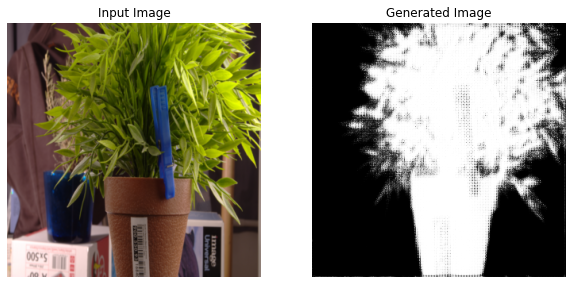

In [8]:
generator.eval()
discriminator.eval()

images, tri_images = next(iter(test_loader))
image = images[0:1].to(device)
tri_image = tri_images[0:1].to(device)

image_np = image.squeeze().to(device).numpy().transpose(1, 2, 0)

input_img = t.cat((image, tri_image), dim=1).to(device)

with t.no_grad():
    fake_alpha = generator(input_img)

fake_alpha_np = fake_alpha.squeeze().to(device).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np)
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(fake_alpha_np, cmap='gray')
axs[1].set_title('Generated Image')
axs[1].axis('off')
plt.show()

In [9]:
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps/Trimap1", transform=transformer)

if len(test_dataset) > 0:
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
else:
    print("Dataset is empty. Check the paths and data.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


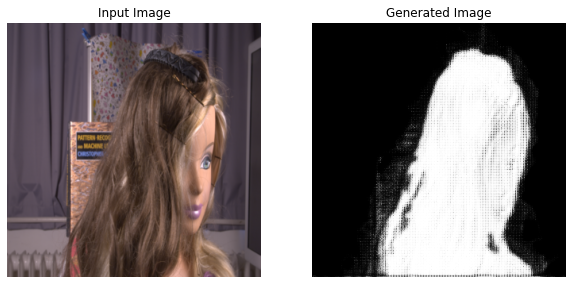

In [10]:
generator.eval()
discriminator.eval()

images, tri_images = next(iter(test_loader))
image = images[0:1].to(device)
tri_image = tri_images[0:1].to(device)

image_np = image.squeeze().to(device).numpy().transpose(1, 2, 0)

input_img = t.cat((image, tri_image), dim=1).to(device)

with t.no_grad():
    fake_alpha = generator(input_img)

fake_alpha_np = fake_alpha.squeeze().to(device).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np)
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(fake_alpha_np, cmap='gray')
axs[1].set_title('Generated Image')
axs[1].axis('off')
plt.show()

In [11]:
t.save(generator.state_dict(), "Model/generator.pth")
t.save(discriminator.state_dict(), "Model/discriminator.pth")